The pre processor is used to process all data into a suitable format for the autoencoder.

In [4]:
# PREPROCESSOR 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Loading Data from CSV
file_path = '/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/RT.IRS_CLEAN.csv'
data = pd.read_csv(file_path)

# Handling DateTime Variables
data['effectiveDate'] = pd.to_datetime(data['effectiveDate'], errors='coerce')
data['effectiveYear'] = data['effectiveDate'].dt.year
data['effectiveMonth'] = data['effectiveDate'].dt.month
data['effectiveDay'] = data['effectiveDate'].dt.day

# Drop the original 'effectiveDate' column
data = data.drop(columns=['effectiveDate'])

# Identifying variable types
numerical_vars = ['leg1FixedRate', 'leg1FixedRatePaymentFrequencyMultiplier', 'effectiveYear', 'effectiveMonth', 'effectiveDay']
categorical_vars = ['action', 'assetClass', 'leg2UnderlierTenorPeriod', 'leg2ResetFrequencyPeriod']

# Preprocessing: Numerical Variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing: Categorical Variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer: Applying transformations to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_vars),
        ('cat', categorical_transformer, categorical_vars)
    ]
)

# Applying Preprocessing
data_preprocessed = pd.DataFrame(preprocessor.fit_transform(data))


Exporting the processed data into a .csv

In [12]:
import os

# Define the path
path = '/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima'

# Check if the path does not exist
if not os.path.exists(path):
    # Create the directory
    os.makedirs(path)

# Now you can save the DataFrame
data_preprocessed.to_csv(f'{path}/processed_data.csv', index=False)



Defining the autoencoder module

In [13]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load preprocessed data
file_path = '/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/processed_data.csv'  # Update this path as per your directory structure
data_preprocessed = pd.read_csv(file_path, header=0)  # Ensuring the first row is treated as header

# Check to make sure the data is in expected format (all numeric, no NaN values)
assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"
assert not data_preprocessed.isnull().any().any(), "NaN values found"

# Dimensions
input_dim = data_preprocessed.shape[1]  # Picks the Number of features = to the number of columns
encoding_dim = int(input_dim / 2)  # Length of encoded representations

# Define the encoder and decoder layers
input_layer = layers.Input(shape=(input_dim,))
encoder_layer = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

# Construct the autoencoder model
autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')



/var/folders/rq/30rpw85n53d2zxnt_c5qnrx40000gn/T/ipykernel_4723/931902708.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"


Training the autoencoder

In [14]:
history = autoencoder.fit(
    data_preprocessed, data_preprocessed,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1  # 10% of data for validation
)


Epoch 1/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5449 - val_loss: 0.4710
Epoch 2/100
164/164 [==============================] - 0s 2ms/step - loss: 0.4123 - val_loss: 0.3663
Epoch 3/100
164/164 [==============================] - 0s 2ms/step - loss: 0.3406 - val_loss: 0.3220
Epoch 4/100
164/164 [==============================] - 0s 2ms/step - loss: 0.3053 - val_loss: 0.2888
Epoch 5/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2796 - val_loss: 0.2652
Epoch 6/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2620 - val_loss: 0.2506
Epoch 7/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2502 - val_loss: 0.2414
Epoch 8/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2407 - val_loss: 0.2340
Epoch 9/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2323 - val_loss: 0.2284
Epoch 10/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2260 - val_lo

Visualize the network Currently not working

In [41]:
# Ensure the model plot is saved and displayed
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Anomaly detection

In [7]:
# Obtain the reconstructed data
predictions = autoencoder.predict(data_preprocessed)

# Measure the reconstruction error
mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)

# Convert mse to a DataFrame for easier handling
mse_df = pd.DataFrame({'reconstruction_error': mse})

# Display basic statistics of the error
print(mse_df.describe())


182/182 [==============================] - 0s 1ms/step
       reconstruction_error
count           5804.000000
mean               0.201609
std                0.375718
min                0.000088
25%                0.033445
50%                0.095346
75%                0.210636
max                3.811505


Visualize

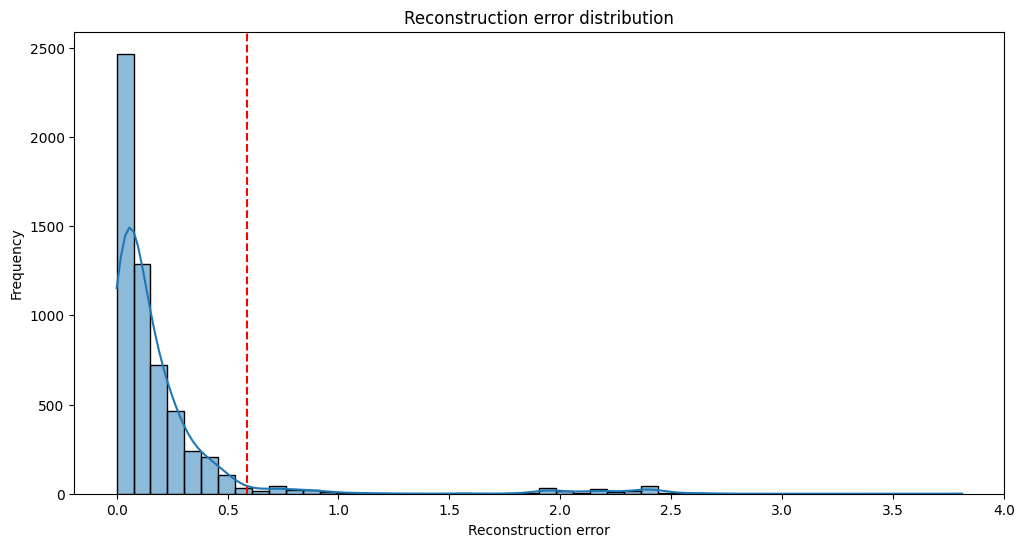

Anomaly threshold: 0.5873169214646455


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_df['reconstruction_error'], 95)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")

